# 03. Single-cell Multiomics data analysis based on _scMaui_ latents

Here, we introduce various cell-type heterogeneity analyses based on _scMaui_ latents. Firstly, we open the RNA-seq data used as input data in the second tutorial and assing the generated latents to "scmaui" field in the _obsm_ annotation. 

In [97]:
from anndata import read_h5ad
import scanpy as sc
import pandas as pd

gex = read_h5ad("../data/GSE194122/gex_preprocessed.hdf5")
latents = pd.read_csv("../data/GSE194122/scmaui_latents.csv", sep="\t", index_col=0)

gex.obsm["scmaui"] = latents

gex

AnnData object with n_obs × n_vars = 2498 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'DonorNumber_colors', 'cell_type_colors', 'dataset_id', 'genome', 'neighbors', 'organism', 'pca', 'umap'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap', 'scmaui'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

UMAP plot below shows the original RNA-seq data representation after PCA application (see the tutorial 01).  

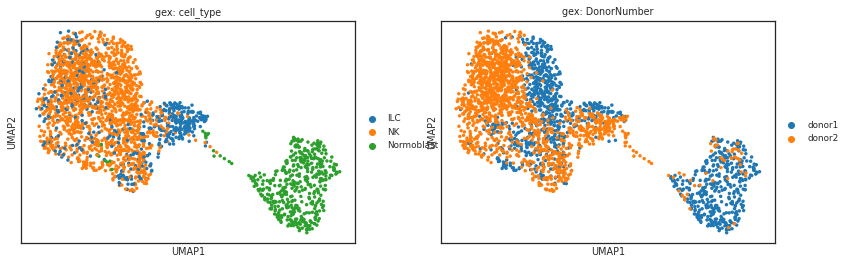

In [98]:
sc.pl.umap(gex, color=["cell_type", "DonorNumber"], 
           title=["gex: cell_type", "gex: DonorNumber"])

### UMAP plot for _scMaui_ latents

Now we create a new UMAP plot for _scMaui_ latents. Neighbours need to be calculated again with the latents indicated as a representation. _scanpy_ also support louvain clustering, so we conduct clustering on the latents as well. 

In [100]:
import scanpy as sc
sc.pp.neighbors(gex, use_rep="scmaui")
sc.tl.umap(gex)
sc.tl.louvain(gex, resolution=0.3, key_added="louvain")

_scMaui_ presents cells with better batch effect correction compared to the UMAP applied to RNA-seq data above. There are four clusters detected within the latents. Cluster 2 and 3 mostly cover normoblast and ILC cells each. On the other hand, NK cells are mainly divided into two clusters, 0 and 1. 

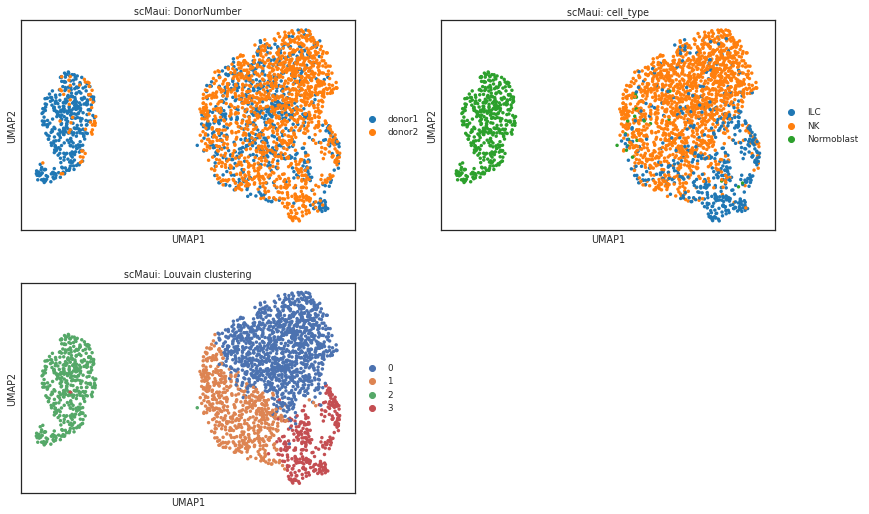

In [101]:
sc.pl.umap(gex, color=["DonorNumber", "cell_type", "louvain"], ncols=2,
           title=["scMaui: DonorNumber", "scMaui: cell_type", "scMaui: Louvain clustering"])

### Cell-type classification analysis

_compute\_roc_ function in _scMaui_ builds a classification model with given classifier and calculates ROC curves for each label over _n_-fold cross vaildation. The default classifier is [linear support vector machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) with regularisation parameter = 0.001. However, users can give any kinds of _sklearn_ classifier.   

In [73]:
from sklearn.metrics import roc_curve, auc
from scmaui.utils import compute_roc


rocs = compute_roc(gex.obsm["scmaui"], gex.obs["cell_type"])
auc_val = auc(rocs["mean"]["FPR"], rocs["mean"]["TPR"])
print(f"mean AUC: {auc_val}")


mean AUC: 0.9422028872715814


The calculated ROC curves can be plotted as follows.

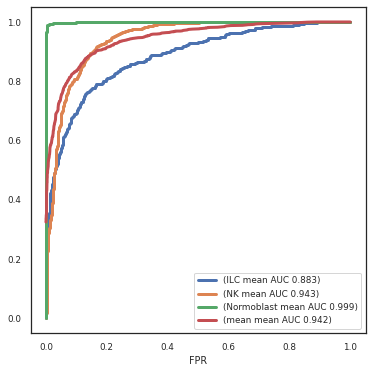

In [74]:
import matplotlib.pyplot as plt
rocs = pd.concat([rocs[k].assign(cell_type=k) for k in rocs.keys()])
fig, ax = plt.subplots(figsize=(6,6))
for c in rocs.cell_type.unique():
    auc_val =  auc(rocs.loc[rocs["cell_type"]==c]["FPR"], 
                  rocs.loc[rocs["cell_type"]==c]["TPR"])
    rocs.loc[rocs["cell_type"]==c].plot('FPR','TPR', ax = ax,
                                             lw=3, label="(%s mean AUC %.3f)"%(c, auc_val))
plt.show()

### Subpopulation analysis

As two different clusters were detected in NK cells, we would like to further analyse those subpopulations. We selected only NK cells. There are three clusters covering this cell type in total, but cluster 0 and 1 take the majority.

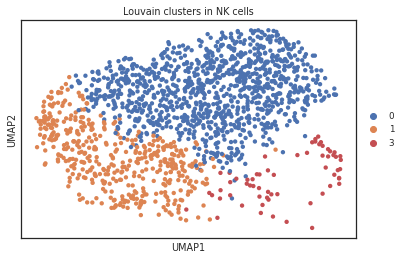

In [102]:
adata_nk = gex[gex.obs["cell_type"]=="NK"]
sc.pl.umap(adata_nk, color=["louvain"], title="Louvain clusters in NK cells")

We rank highly expressed genes for each cluster and plot those genes respectively. 

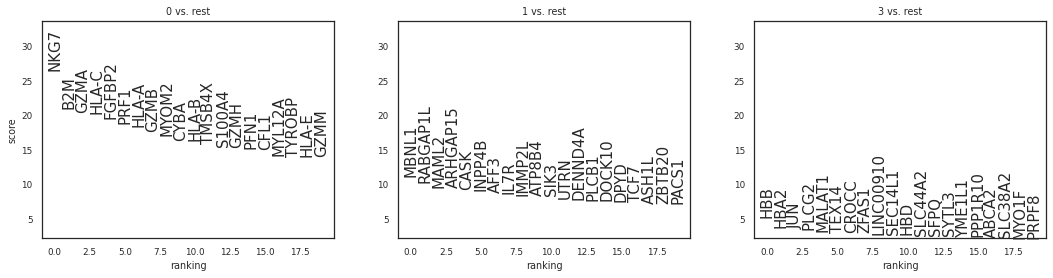

In [104]:
sc.tl.rank_genes_groups(adata = adata_nk, groupby="louvain")
sc.pl.rank_genes_groups(adata = adata_nk, ncols=3, fontsize=15)

Some of the ranked genes were identified as marker genes for NK cell subpopulations by [Ren et al.](https://onlinelibrary.wiley.com/doi/pdf/10.1111/jcmm.17159). Thus we investigate S100A4, GZMB, FGFBP2 as CD56$^{dim}$ subpopulation marker genes and IL7R, TCF7, GZMK as CD56$^{bright}$ subpopulation marker genes according to Ren et al.

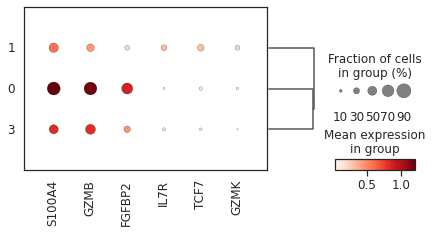

In [108]:
import seaborn as sns
sns.set(font_scale=1.2, style="white")
sc.pl.dotplot(adata = adata_nk, groupby = "louvain", 
                     var_names=["S100A4", "GZMB", "FGFBP2", "IL7R", "TCF7","GZMK"],
                     figsize=(7,3), dendrogram=True)

From the dotplot above, we realise that cluster 0 is close to CD56$^{dim}$, whereas cluster 1 is more corresponding to CD56$^{bright}$. The result makes an agreement with the expression level of each gene below. 

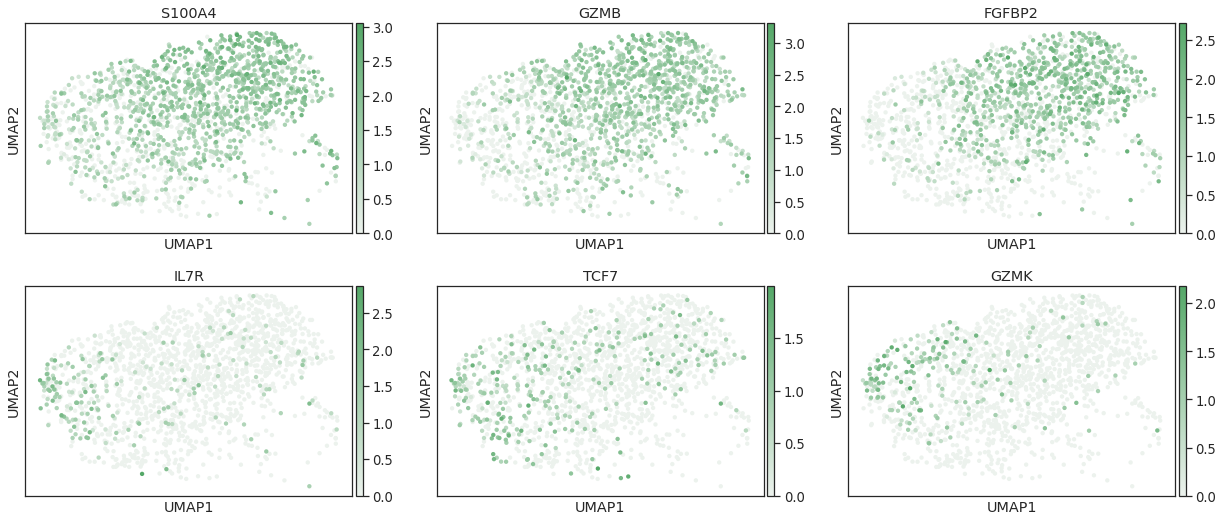

In [109]:
sc.pl.umap(adata_nk, color=["S100A4", "GZMB", "FGFBP2", "IL7R", "TCF7","GZMK"], 
           cmap=sns.color_palette("light:g", as_cmap=True), ncols=3)

### Additional analyses with the clustering results

Furthermore, we calculate highly variable genes over all cells and plot the expression of top 50 genes separated in the detected clusters. UBE4B, DDI2, ESPN, UBR4 and E2F2 genes are particularly highly expressed in cluster 2 which mostly comprises the normoblast population. 

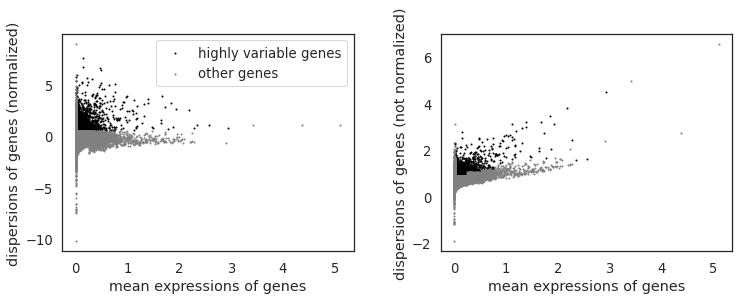

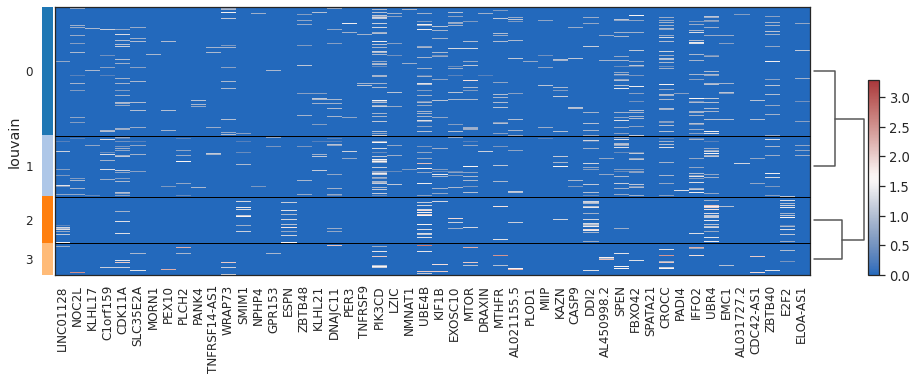

In [110]:
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(gex)
sc.pl.highly_variable_genes(gex)
sc.pl.heatmap(gex, var_names=gex.var_names[gex.var["highly_variable"]][:50], dendrogram=True,
              groupby=["louvain"], cmap="vlag", figsize=(15,5))

We also compute the connectivity between clusters using [PAGA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1663-x). The result shows that cluster 2 is clearly dissimilar from all other clusters, while cluster 1 shows a strong connection with both cluster 3 and cluster 0.

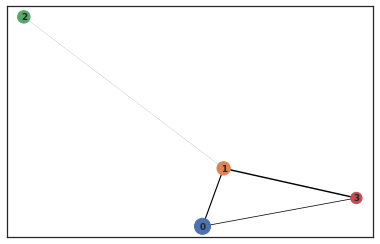

In [95]:
sc.tl.paga(gex, groups="louvain")
sc.pl.paga(gex)